In [17]:
import torch
import math
from torch import nn
from torch.nn import functional as F
import logging
from matplotlib import pyplot as plt
import seaborn as sb
import pandas as pd

logger = logging.getLogger(__name__)

In [2]:
n_embedding = 8
n_layers = 12

In [3]:
class RWKV_CM(torch.jit.ScriptModule):
    def __init__(self, config, index):
        super(RWKV_CM, self).__init__()
        layers = config.number_of_layers
        hidden_size = config.hidden_size
        self.time_shift = nn.ZeroPad2d((0, 0, 1, -1))
        with torch.no_grad():
            time_ratio = 1 - (index / layers)
            x = torch.ones(1, 1, hidden_size)
            for i in range(hidden_size):
                x[0, 0, i] = i / hidden_size
            self.time_mix_k = nn.Parameter(torch.pow(x, time_ratio))
            self.time_mix_r = nn.Parameter(torch.pow(x, time_ratio))

        h_up = hidden_size * 4

        self.key = nn.Linear(hidden_size, h_up, bias=False)
        self.value = nn.Linear(h_up, h_up, bias=False)
        self.r = nn.Linear(h_up, hidden_size, bias=False)

        self.value.scale_init = 0
        self.r.scale_init = 0

    @torch.jit.script_method
    def forward(self, x):
        xx = self.time_shift(x)
        xk = x * self.time_mix_k + xx * (1 - self.time_mix_k)
        xr = x * self.time_mix_r + xx * (1 - self.time_mix_r)
        k = self.key(xk)
        kv = self.value(F.silu(k))
        out = F.sigmoid(self.r(xr)) + kv
        return out

In [4]:
class RWKV_TimeMix(torch.jit.ScriptModule):
    def __init__(self, config, index):
        super(RWKV_TimeMix, self).__init__()
        layers = config.number_of_layers
        hidden_size = config.hidden_size
        self.time_shift = nn.ZeroPad2d((0, 0, 1, -1))
        with torch.no_grad():
            time_ratio_0_to_1 = (index / (layers - 1))
            time_ratio_1_to_pz = (1 - (index / layers))
            decay_speed = torch.ones(hidden_size)
            for i in range(hidden_size):
                decay_speed[i] = -5 + 8 * (i / (hidden_size - 1)) ** (0.7 + 1.3 * time_ratio_0_to_1)
            self.time_decay = nn.Parameter(decay_speed)
            zigzag = (torch.tensor([(i + 1) % 3 - 1 for i in range(hidden_size)]) * 0.5)
            self.time_first = nn.Parameter(torch.ones(hidden_size) * math.log(0.3) + zigzag)
            x = torch.ones(1, 1, hidden_size)
            for i in range(hidden_size):
                x[0, 0, i] = i / hidden_size
            self.time_mix_k = nn.Parameter(torch.pow(x, time_ratio_1_to_pz))
            self.time_mix_v = nn.Parameter(torch.pow(x, time_ratio_1_to_pz) + 0.3 * time_ratio_0_to_1)
            self.time_mix_r = nn.Parameter(torch.pow(x, 0.5 * time_ratio_1_to_pz))
        h_up = hidden_size * 4
        self.k = nn.Linear(hidden_size, h_up, bias=False)
        self.v = nn.Linear(hidden_size, h_up, bias=False)
        self.r = nn.Linear(hidden_size, h_up, bias=False)
        self.o = nn.Linear(h_up, hidden_size, bias=False)
        self.k.scale_init = 0
        self.r.scale_init = 0
        self.o.scale_init = 0

    @torch.jit.script_method
    def func_jump(self, x):
        xx = self.time_shift(x)
        k = x * self.time_mix_k + xx * (1 - self.time_mix_k)
        v = x * self.time_mix_v + xx * (1 - self.time_mix_v)
        r = x * self.time_mix_r + xx * (1 - self.time_mix_r)

        k = self.k(k)
        v = self.v(v)
        sr = torch.sigmoid(self.r(r))
        return sr, k, v

    def forward(self, x):
        B, T, C = x.size()

        sr, k, v = self.jit_func(x)
        # TODO: implement run_cuda in pytorch
        # rwkv = sr * RUN_CUDA(B, T, C, self.time_decay, self.time_first, k, v)
        # rwkv = self.output(rwkv)
        # return rwkv
        return ...

In [28]:
list_time_mix = []
list_ratio = []
list_speed = []
list_0_to_1_ratio = []
crack = []
for v in range(n_layers):
    ratio_1_to_almost0 = (1 - (v / n_layers))
    list_time_mix.append(ratio_1_to_almost0)
    ratio_0_to_1 = (v / (n_layers - 1))
    list_0_to_1_ratio.append(ratio_0_to_1)
    decay_speed = torch.ones(n_embedding)
    for n in range(n_embedding):
        decay_speed[n] = -5 + 8 * (n / (n_embedding - 1)) ** (0.7 + 1.3 * ratio_0_to_1)
    list_speed.append(decay_speed)
    x = torch.ones(1, 1, n_embedding)
    for n in range(n_embedding):
        x[0, 0, n] = n / n_embedding
    crack.append(x)

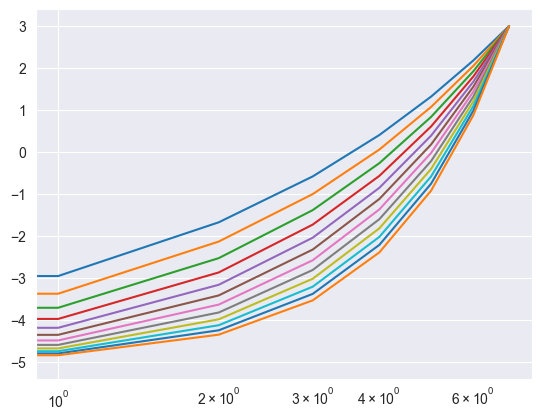

In [22]:
for crt in list_speed:
    plt.semilogx(crt.cpu().numpy())

In [34]:
torch.exp(torch.cat(crack).view(len(crack), -1))

tensor([[1.0000, 1.1331, 1.2840, 1.4550, 1.6487, 1.8682, 2.1170, 2.3989],
        [1.0000, 1.1331, 1.2840, 1.4550, 1.6487, 1.8682, 2.1170, 2.3989],
        [1.0000, 1.1331, 1.2840, 1.4550, 1.6487, 1.8682, 2.1170, 2.3989],
        [1.0000, 1.1331, 1.2840, 1.4550, 1.6487, 1.8682, 2.1170, 2.3989],
        [1.0000, 1.1331, 1.2840, 1.4550, 1.6487, 1.8682, 2.1170, 2.3989],
        [1.0000, 1.1331, 1.2840, 1.4550, 1.6487, 1.8682, 2.1170, 2.3989],
        [1.0000, 1.1331, 1.2840, 1.4550, 1.6487, 1.8682, 2.1170, 2.3989],
        [1.0000, 1.1331, 1.2840, 1.4550, 1.6487, 1.8682, 2.1170, 2.3989],
        [1.0000, 1.1331, 1.2840, 1.4550, 1.6487, 1.8682, 2.1170, 2.3989],
        [1.0000, 1.1331, 1.2840, 1.4550, 1.6487, 1.8682, 2.1170, 2.3989],
        [1.0000, 1.1331, 1.2840, 1.4550, 1.6487, 1.8682, 2.1170, 2.3989],
        [1.0000, 1.1331, 1.2840, 1.4550, 1.6487, 1.8682, 2.1170, 2.3989]])

In [13]:
list_speed

[tensor([-5.0000, -2.9511, -1.6715, -0.5791,  0.4071,  1.3212,  2.1817,  3.0000]),
 tensor([-5.0000, -3.3720, -2.1296, -1.0004,  0.0611,  1.0748,  2.0520,  3.0000]),
 tensor([-5.0000, -3.7065, -2.5246, -1.3815, -0.2628,  0.8380,  1.9247,  3.0000]),
 tensor([-5.0000, -3.9722, -2.8653, -1.7263, -0.5660,  0.6104,  1.7997,  3.0000]),
 tensor([-5.0000, -4.1834, -3.1590, -2.0382, -0.8498,  0.3916,  1.6770,  3.0000]),
 tensor([-5.0000, -4.3511, -3.4124, -2.3204, -1.1154,  0.1815,  1.5564,  3.0000]),
 tensor([-5.0000, -4.4845, -3.6309, -2.5758, -1.3640, -0.0205,  1.4381,  3.0000]),
 tensor([-5.0000, -4.5904, -3.8193, -2.8067, -1.5967, -0.2147,  1.3218,  3.0000]),
 tensor([-5.0000, -4.6745, -3.9818, -3.0157, -1.8145, -0.4012,  1.2077,  3.0000]),
 tensor([-5.0000, -4.7414, -4.1219, -3.2048, -2.0183, -0.5805,  1.0957,  3.0000]),
 tensor([-5.0000, -4.7945, -4.2427, -3.3759, -2.2091, -0.7528,  0.9856,  3.0000]),
 tensor([-5.0000, -4.8367, -4.3469, -3.5306, -2.3878, -0.9184,  0.8776,  3.0000])]